In [8]:
from PIL import Image
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
import torch
import random
from torch.nn.functional import cosine_similarity
import pickle
import numpy as np
import matplotlib.pyplot as plt
import copy

In [9]:
def get_embeddings_from_img(image_path, image_transforms, device, embedd_model):

    # get image features
    try:
        image = Image.open(image_path).convert("RGB")
        image = image_transforms(image).to(device)

        with torch.inference_mode():
            image_feat = embedd_model(image.unsqueeze(0)).squeeze(0).view(-1)
            image_feat = image_feat.cpu().numpy()
        
        return image_feat
    
    except Exception as e:
        print(f"[ERROR] Error processing image {image_path}: {e}")

In [10]:
def get_random_images_from_dataset(imgs_paths_lst, num_imgs, random_seed):
    
    random.seed(random_seed)
    random.shuffle(imgs_paths_lst)
    
    selected_imgs = random.sample(imgs_paths_lst, num_imgs)
    
    return selected_imgs

In [11]:
def compute_images_similarity(img_feature, imgs_features_lst):
        
    features_array = torch.tensor(np.vstack(imgs_features_lst))
    img_feature = torch.tensor(img_feature).unsqueeze(0)
    similarity = cosine_similarity(img_feature, features_array, dim=1)
    
    cos_distance = 1 - similarity
    
    return cos_distance

In [19]:
def show_similar_images(img_path, imgs_paths_lst, cos_distance, num_showed_imgs):
    
    fig_1, axes_1 = plt.subplots(figsize=(8, 3))
    
    # show initial image
    image = Image.open(img_path).convert("RGB")
    plt.imshow(image)
    img_parts_path_lst = img_path.split("\\")
    plt.title(f"class: {img_parts_path_lst[-2]}\nimage: {img_parts_path_lst[-1]}")
    plt.axis('off')
    plt.show()
    
    # -------------
    
    num_row = 1
    idxs = cos_distance.argsort()[1:num_showed_imgs+1]
    
    fig_2, axes_2 = plt.subplots(num_row, num_showed_imgs, figsize=(15, 5))
    
    for i, idx in enumerate(idxs):
        img_path = imgs_paths_lst[idx]
        image = Image.open(img_path).convert("RGB")
        
        axes_2[i].imshow(image)
        axes_2[i].set_title(f"cosine similarity: {cos_distance[idx]:.3f}")
        axes_2[i].axis('off')
    plt.show()

In [20]:
def test_similarity_model(
    features_data_path,
    num_imgs,
    random_seed,
    num_showed_imgs,
):
    
    # set model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = resnet50(weights=ResNet50_Weights.DEFAULT).to(device).eval()
    embedd_model = torch.nn.Sequential(*list(model.children())[:-1])
    
    # set imagenet transforms
    image_transforms = transforms.Compose(
        [
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    
    # read imgs features data
    with open(features_data_path, "rb") as f:
        imgs_features = pickle.load(f)
    
    imgs_paths_lst = []
    imgs_features_lst = [] 
    
    for feat in imgs_features:
        imgs_paths_lst.append(feat["path"])
        imgs_features_lst.append(feat["features"])
        
    imgs_paths_lst_copy = copy.deepcopy(imgs_paths_lst)
    
    # get test images lst    
    random_imgs_lst = get_random_images_from_dataset(
        imgs_paths_lst=imgs_paths_lst_copy,
        num_imgs=num_imgs,
        random_seed=random_seed,
    )
    
    for random_img_path in random_imgs_lst:
        random_img_feature = get_embeddings_from_img(
            image_path=random_img_path,
            image_transforms=image_transforms,
            device=device,
            embedd_model=embedd_model,
        )
        
        cos_distance = compute_images_similarity(
            img_feature=random_img_feature,
            imgs_features_lst=imgs_features_lst,
        )
        
        show_similar_images(
            img_path=random_img_path,
            imgs_paths_lst=imgs_paths_lst,
            cos_distance=cos_distance,
            num_showed_imgs=num_showed_imgs,
        )

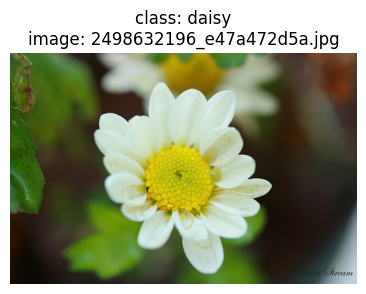

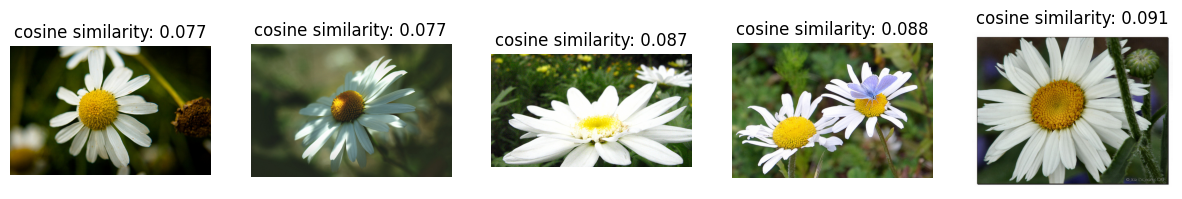

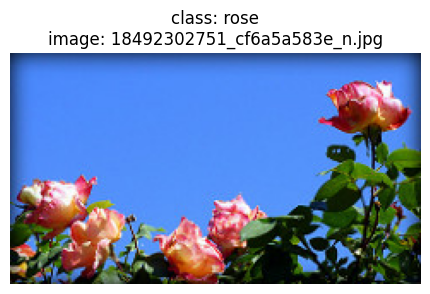

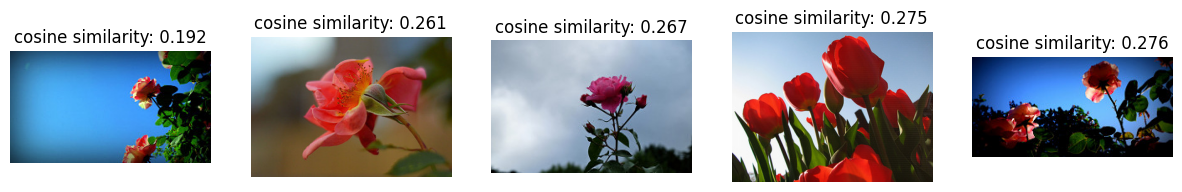

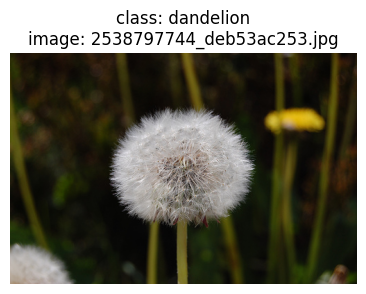

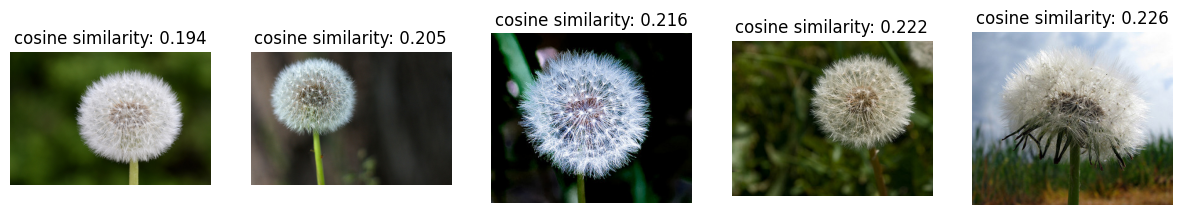

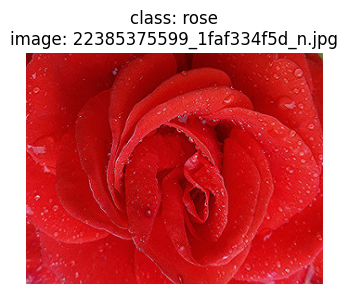

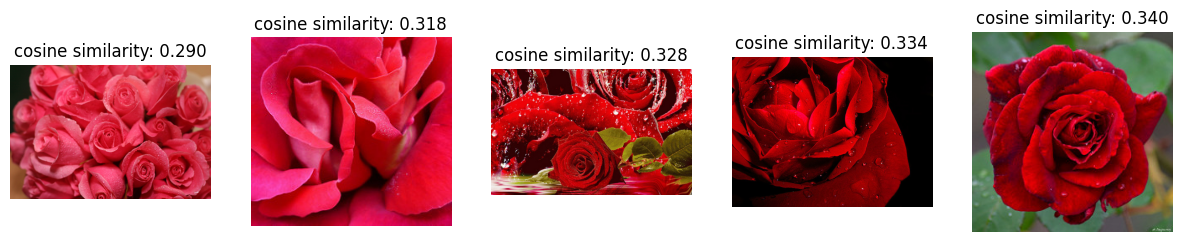

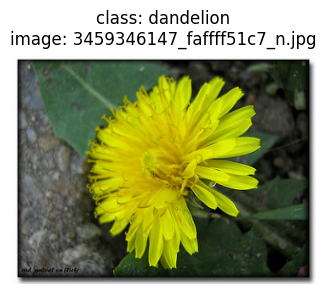

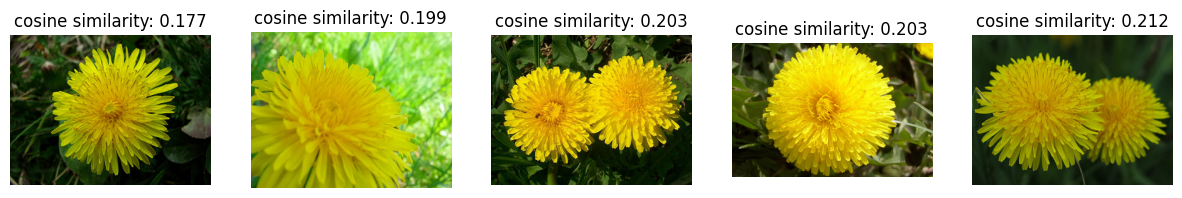

In [22]:
test_similarity_model(
    features_data_path="../data/features.pkl",
    num_imgs=5,
    random_seed=42,
    num_showed_imgs=5,
)